In [23]:
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = "Data/ukcp09_gridded-land-obs-daily_timeseries_mean-temperature_000000E_500000N_19600101-20161231.csv"
data = pd.read_csv(path, header=[0,1], index_col=0, parse_dates=True)

In [3]:
dates_to_remove = [datetime.date(datetime.strptime(str(y)+"-02-29", '%Y-%m-%d')) for y in range(1960, 2017, 4)]
data = data.drop(dates_to_remove)
series = data["22500"]["547500"]

In [4]:
series.head()

1960-01-01    6.20
1960-01-02    4.53
1960-01-03    8.48
1960-01-04    7.02
1960-01-05    2.49
Name: 547500, dtype: float64

In [5]:
decomp_freq = 365

In [6]:
res = sm.tsa.seasonal_decompose(series, freq=decomp_freq, model='additive')

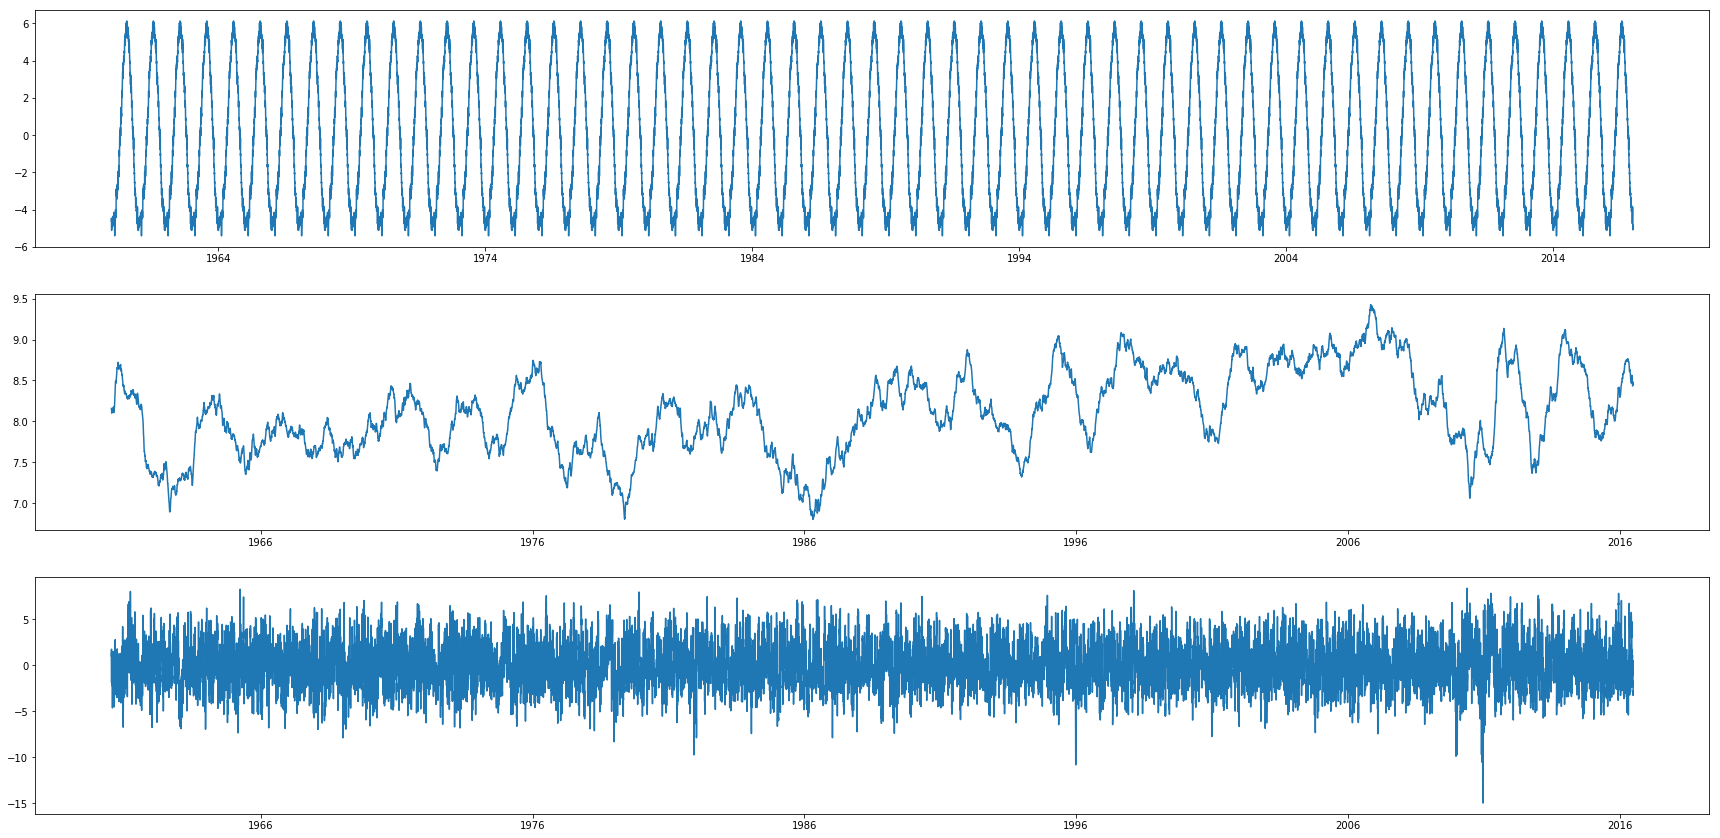

In [7]:
plt.figure(figsize=(30,20))
plt.subplot(411)
plt.plot(res.seasonal)
plt.subplot(412)
plt.plot(res.trend)
plt.subplot(413)
plt.plot(res.resid)
plt.show()

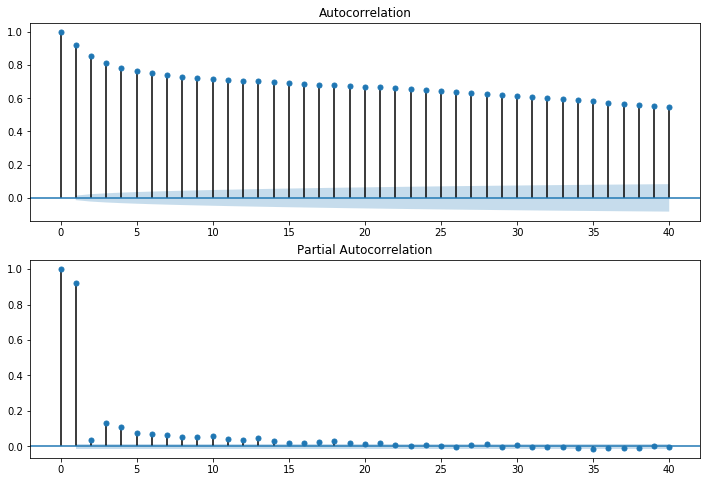

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

Figure(864x1440)


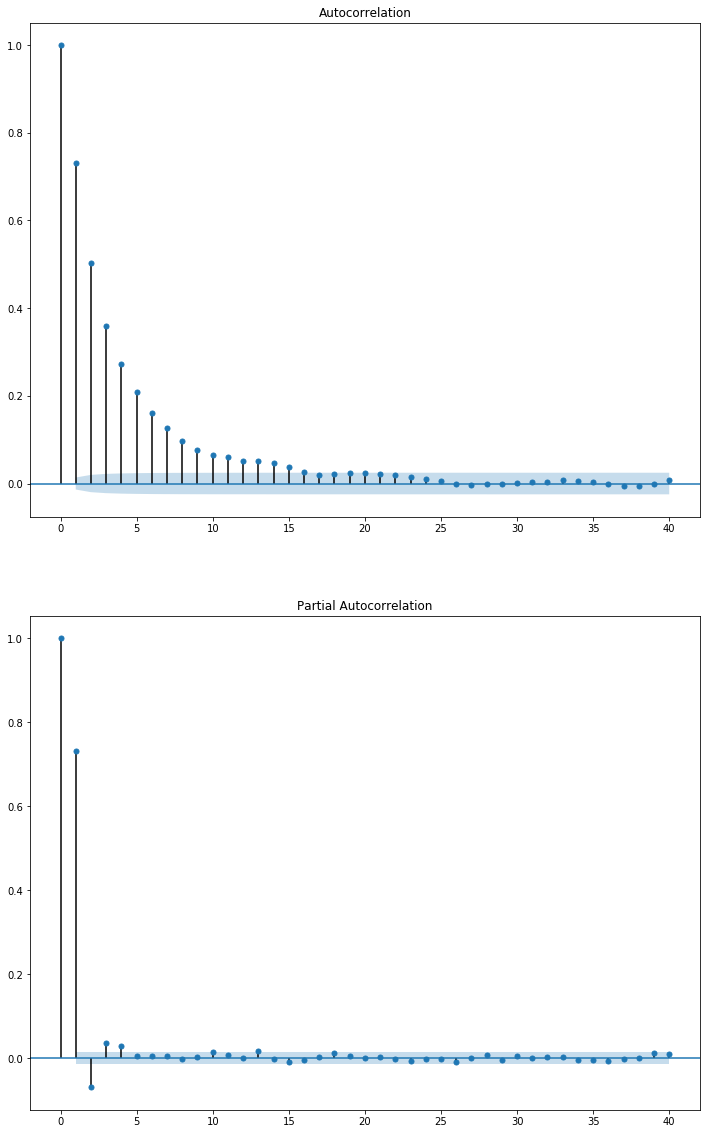

In [46]:
resid = res.resid.dropna()
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1, alpha=0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

Observations :
+ decroissance exponentielle de la fonction d'autocorrélation
+ autocorrélation partielle nulle pour h > 4

In [58]:
acf, conf_acf = sm.tsa.acf(resid, alpha=0.05)

Méthode du coin pour estimer p,q (choix d'un modèle ARMA)

In [119]:
def delta(acf, j, k):
    M = np.array([acf[k+1-i:k+j+2-i] for i in range(j+1)])
    M = np.zeros((j+1,j+1))
    for i in range(j+1):
        for l in range(j+1):
            M[i,l] = acf[abs(k+1-i+l)]
    return np.linalg.det(M)

In [125]:
def coin(acf, maxp = 10, maxq = 10):
    D = np.zeros((maxp, maxq))
    for i in range(maxp):
        for j in range(maxq):
            D[i,j] = round(delta(acf, i, j),4)
    return D

In [127]:
print(coin(acf, maxp=5, maxq=10))

[[ 7.314e-01  5.027e-01  3.592e-01  2.724e-01  2.092e-01  1.619e-01
   1.270e-01  9.810e-02  7.600e-02  6.590e-02]
 [ 3.220e-02 -1.010e-02 -7.900e-03 -1.000e-03 -3.000e-04 -4.000e-04
   2.000e-04 -0.000e+00 -7.000e-04 -2.000e-04]
 [ 7.800e-03  7.000e-04  1.000e-04 -0.000e+00 -0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-2.800e-03  1.000e-04 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
  -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00]
 [ 2.000e-04 -0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00
  -0.000e+00 -0.000e+00  0.000e+00  0.000e+00]]


Ok, mais à quelle valeur comparer pour test de nullité? Cours pas très clair... cf p 169 -> comment estimer la variance ?

In [122]:
delta(acf,3,0)

-0.002811784233462201

In [90]:
acf[0+1-i:k+j+2-i]

array([ 1.00000000e+00,  7.31362953e-01,  5.02667935e-01,  3.59239265e-01,
        2.72357382e-01,  2.09201712e-01,  1.61890496e-01,  1.27021039e-01,
        9.81196594e-02,  7.60120039e-02,  6.58850530e-02,  5.97171587e-02,
        5.22112345e-02,  5.16928919e-02,  4.71060150e-02,  3.66703952e-02,
        2.57512596e-02,  2.00746305e-02,  2.20759004e-02,  2.44510091e-02,
        2.41704448e-02,  2.28242284e-02,  1.99827368e-02,  1.43036582e-02,
        9.51010503e-03,  5.90903167e-03, -8.96409693e-05, -3.26941414e-03,
       -9.14565175e-04, -9.56919542e-04,  1.17124102e-03,  2.74031485e-03,
        4.59127510e-03,  7.11188326e-03,  6.21701944e-03,  2.85515953e-03,
       -2.16991357e-03, -5.09228033e-03, -5.71610798e-03, -1.77267703e-04,
        7.44139318e-03])